In [1]:
import numpy as np

from Leviathan.other_games import (
    Game, SBAgent, GameWHistory,
    suicide_bomber_pay_off, RPS_pay_off, Hawk_Dove_pay_off
)
import matplotlib.pyplot as plt
from typing import List

from utils import save

import networkx as nx 
import nxviz as nv

/Users/Harry/opt/miniconda3/envs/arm30/lib/python3.10/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


## Analyze Tools 

In [2]:
def average_strategy(
    member_list: List[SBAgent]
):
    strategy_count = np.zeros_like(member_list[0].strategy)
    for mem in member_list:
        if member_list[0].mixed_strategy:
            strategy_count += mem.strategy
        else:
            strategy_count[mem.decision()] += 1

    return strategy_count / len(member_list)

## Hawk Dove game

In [3]:
resource = 2
conflict = 2
off_set = -1

In [4]:
Hawk_Dove = Hawk_Dove_pay_off(resource, conflict, off_set)

game = GameWHistory(
    init_member_num=50,
    pay_off_matrix=Hawk_Dove,
    history_len=3,
    mixed_strategy=True,
    random_seed=None,
)

#### Run

In [5]:
round_num = 200
game_in_round = 5000

discard_rate = 0.1
mutation_rate = 0.01

In [6]:
ave_str_list = [average_strategy(game.current_members)]

In [7]:
for _ in range(round_num):
    # game.forget()

    game.discard_randomly(discard_rate)
    # game.discard_member_by_payoff(discard_rate)
    game.bear_new_member_by_payoff()
    game.mutation(mutation_rate)

    game.reset_fitness()
    game.multiple_game(game_in_round)

    ave_str_list.append(average_strategy(game.current_members))


In [8]:
path = save.datetime_dir("./data")

save.dill_dump(game, path + "HD game.dill")

Current save directory: ./data/May/05_11-37/


## Plot

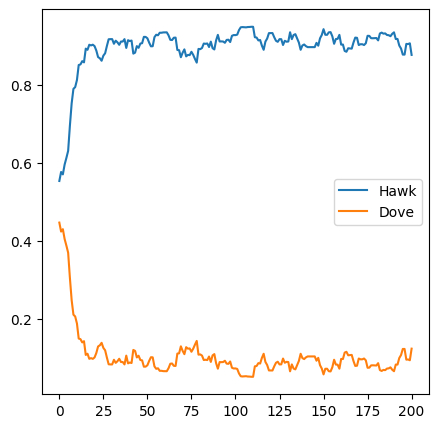

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(ave_str_list, label=["Hawk", "Dove"])
ax.legend()
plt.show()

In [10]:
# game.multiple_game(200000)

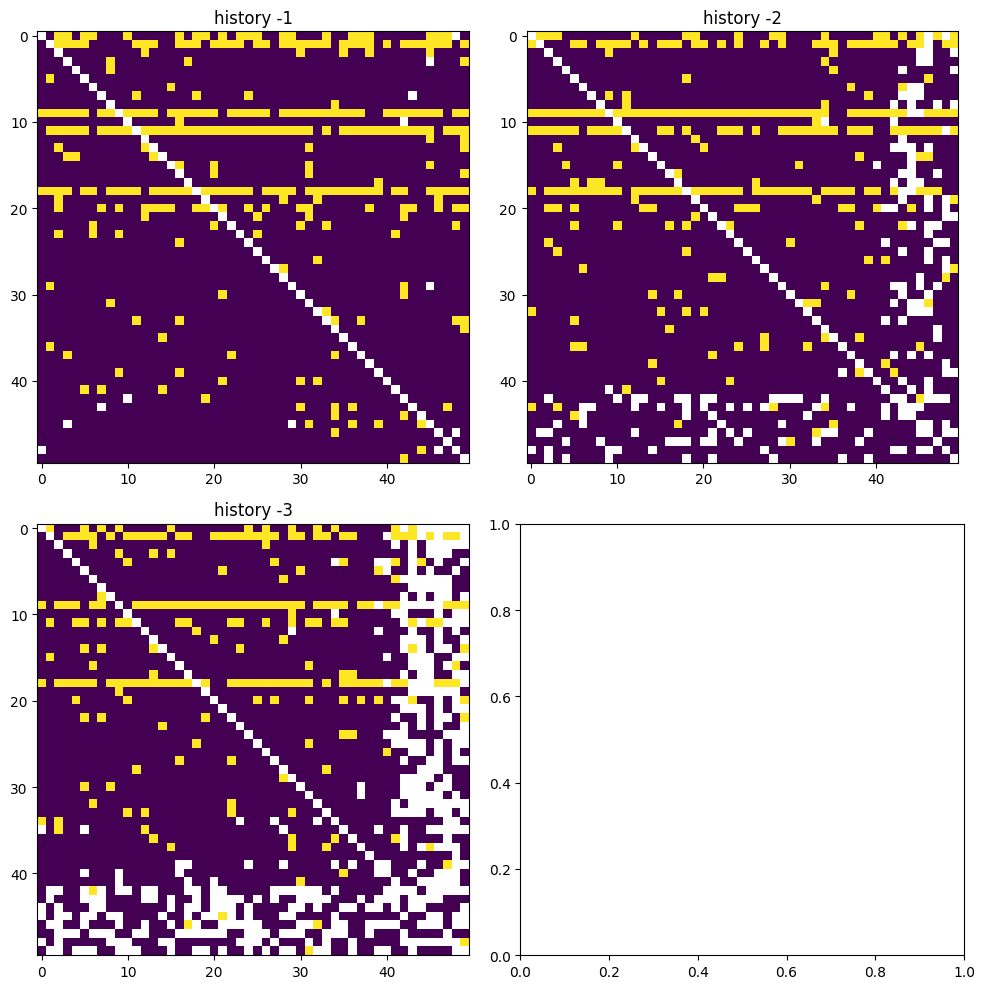

In [11]:
# plot the relationship matrices
row = 2
col = 2
fig, axs = plt.subplots(row, col, figsize=(10, 10))
for idx, (key, rela) in enumerate(game.relationship_dict.items()):
    ax = axs[idx // row, idx % col]
    im = ax.imshow(rela)
    ax.set_title(key)
    
# colorbar for the rightmost plot
# fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

## Build relationship network

In [12]:
his_1 = game.relationship_dict["history -1"]

# his_1_hawk = his_1.copy()
# his_1_hawk[his_1_hawk == 1] = np.nan
# his_1_hawk[his_1_hawk == 0] = 1

# his_1_dove = his_1.copy()
# his_1_dove[his_1_dove == 0] = np.nan

G_his_1_hawk = nx.DiGraph()
G_his_1_hawk.add_nodes_from(range(len(his_1)))
G_his_1_hawk.add_edges_from(np.argwhere(his_1 == 0))
G_his_1_hawk.name = "Hawk"

G_his_1_dove = nx.DiGraph()
G_his_1_dove.add_nodes_from(range(len(his_1)))
G_his_1_dove.add_edges_from(np.argwhere(his_1 == 1))
G_his_1_dove.name = "Dove"


In [13]:
his_1_mutual = his_1.copy()
his_1_mutual[his_1 != his_1.T] = np.nan
np.fill_diagonal(his_1_mutual, np.nan)

# his_1_mut_friend = his_1_mutual.copy()
# his_1_mut_friend[his_1_mut_friend == 0] = np.nan

# his_1_mut_enemy = his_1_mutual.copy()
# his_1_mut_enemy[his_1_mut_enemy == 1] = np.nan
# his_1_mut_enemy[his_1_mut_enemy == 0] = 1

G_his_1_mut_friend = nx.Graph()
G_his_1_mut_friend.add_nodes_from(range(len(his_1)))
G_his_1_mut_friend.add_edges_from(np.argwhere(his_1_mutual == 1))
G_his_1_mut_friend.name = "Friend"

G_his_1_mut_enemy = nx.Graph()
G_his_1_mut_enemy.add_nodes_from(range(len(his_1)))
G_his_1_mut_enemy.add_edges_from(np.argwhere(his_1_mutual == 0))
G_his_1_mut_enemy.name = "Enemy"

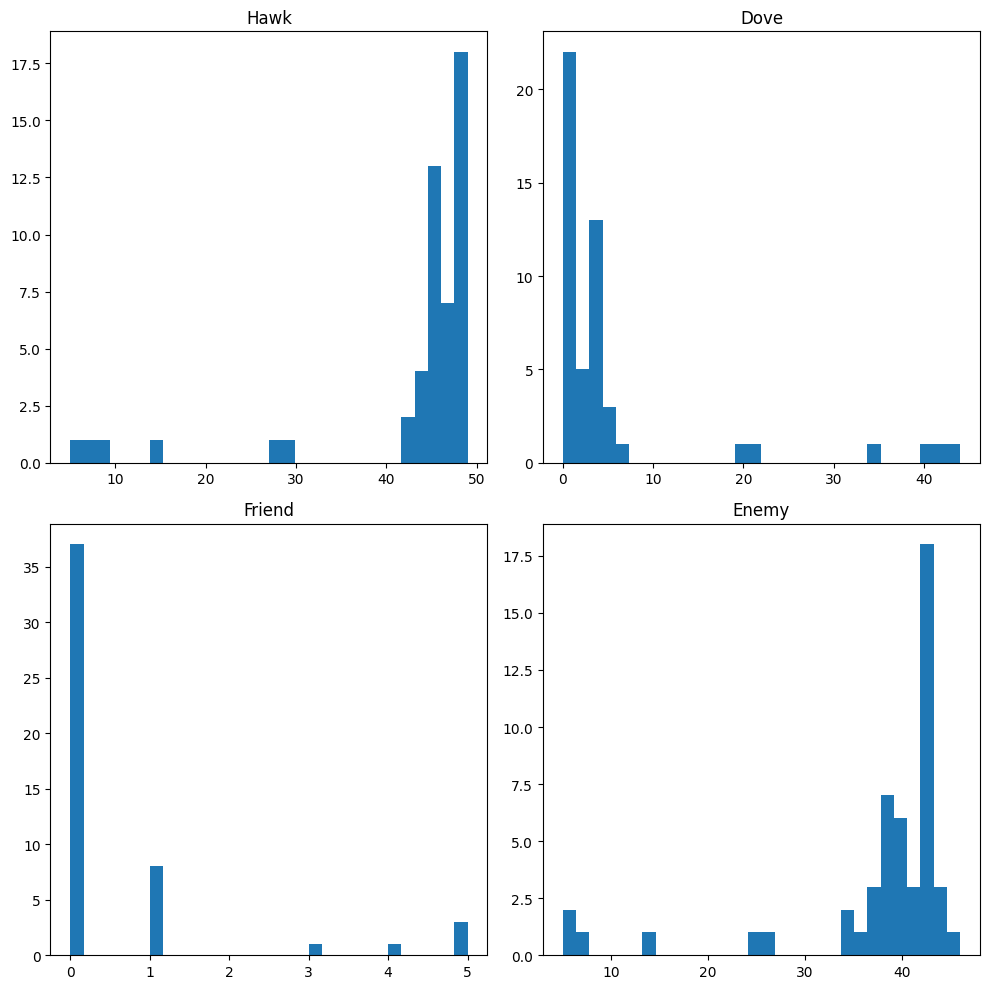

In [14]:
# plot degree distribution for G_his_1_hawk, G_his_1_dove, G_his_1_mut_friend, G_his_1_mut_enemy
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for idx, G in enumerate([
    G_his_1_hawk, G_his_1_dove, 
    G_his_1_mut_friend, G_his_1_mut_enemy
]):
    ax = axs[idx]
    try:
        degree = [d for n, d in G.out_degree()]
    except AttributeError:
        degree = [d for n, d in G.degree()]

    ax.hist(degree, bins=30)
    ax.set_title(G.name)

plt.tight_layout()
plt.show()

There seems to be three kinds of players: 
all hawk, all dove, and mixed.

In [15]:
def heritage(mem):
    strategy_list = []
    while mem.parent is not None:
        strategy_list.append(mem.strategy)
        print(mem.name)
        mem = mem.parent

    return strategy_list